<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/image_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'

image_files = os.listdir(image_dir)
print(len(image_files))

# get the path of image in the list
image_path = os.path.join(image_dir, image_files[0])

579


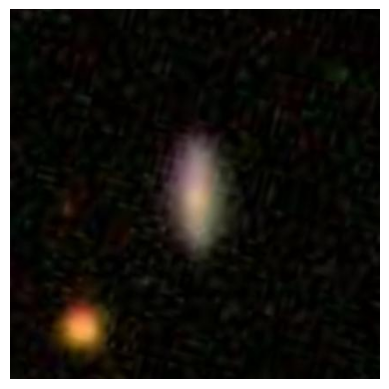

In [3]:
# print out the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [78]:
import pandas as pd

csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_label.csv'
column_names = ['index', 'class']

df = pd.read_csv(csv_file_path, names=column_names)
# create a dictionary for index and class
index_to_class = dict(zip(df['index'], df['class']))

Index: 115384
Class0


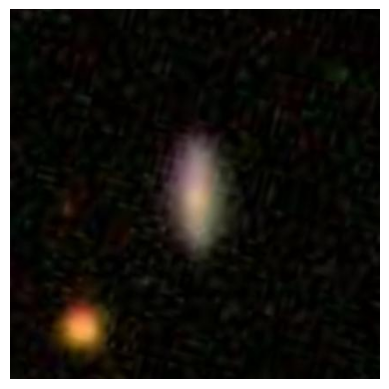

In [79]:
image_path = os.path.join(image_dir, image_files[0])
filename = os.path.basename(image_path)
index = filename.split('.')[0]
index = int(index)

# Print the index
print("Index:", index)
print(index_to_class[index])

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

Refer to the filters used in exercise 7

In [4]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib

(424, 424, 3)


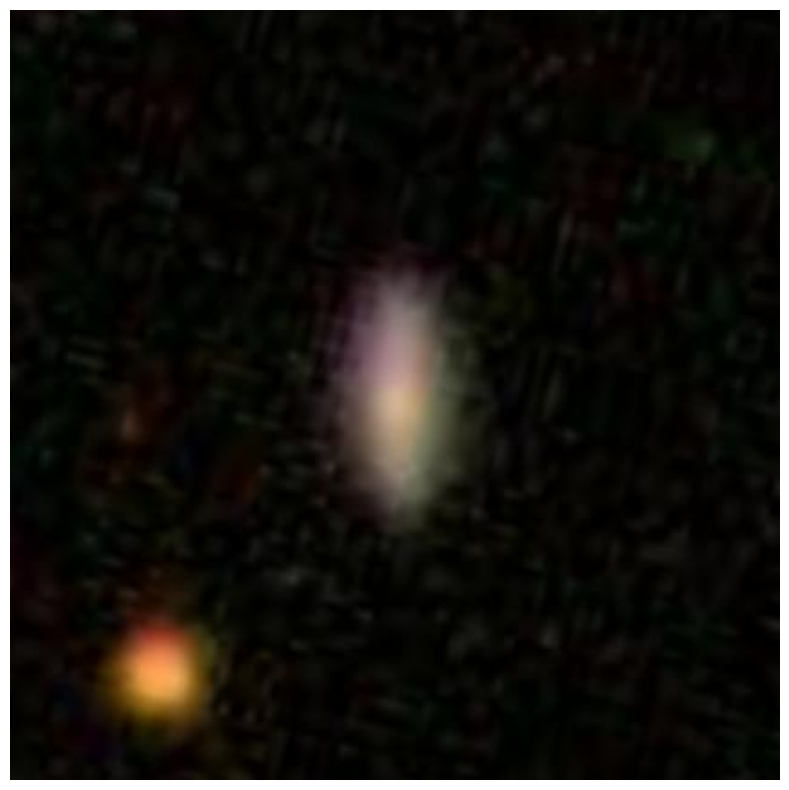

In [5]:
image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
print(im.shape)

# display the image
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(im)
plt.show()

In [6]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(15, 10))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

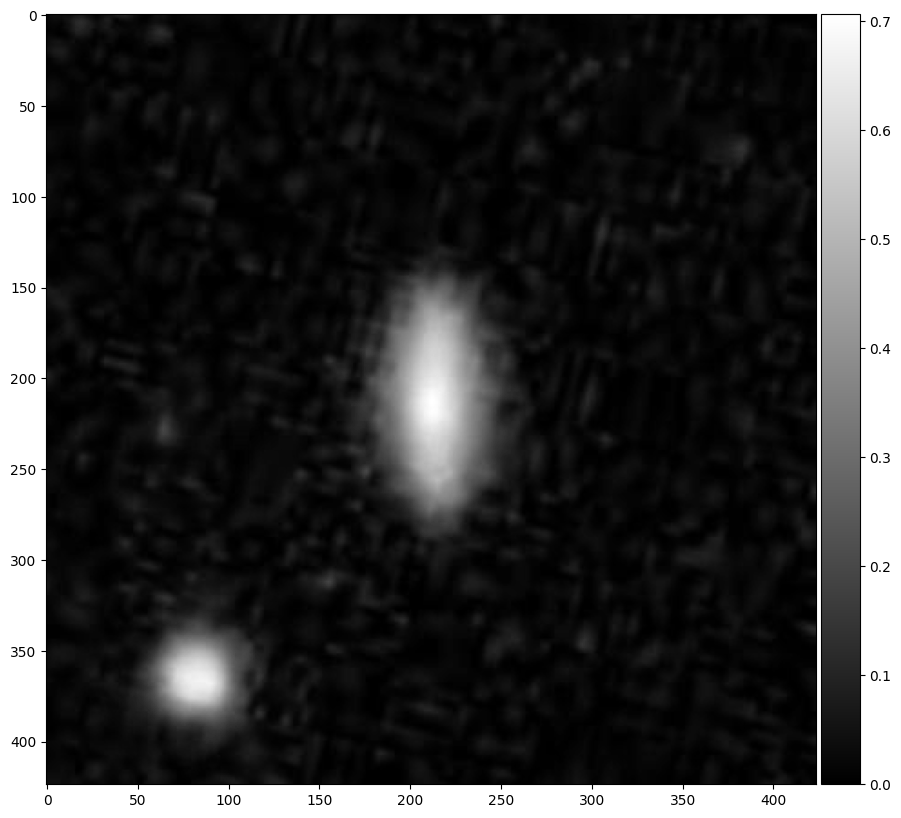

In [48]:
# convert to grayscale
def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

im_gray = grayscale_preprocessing(im)
display_img_colorbar(im_gray)

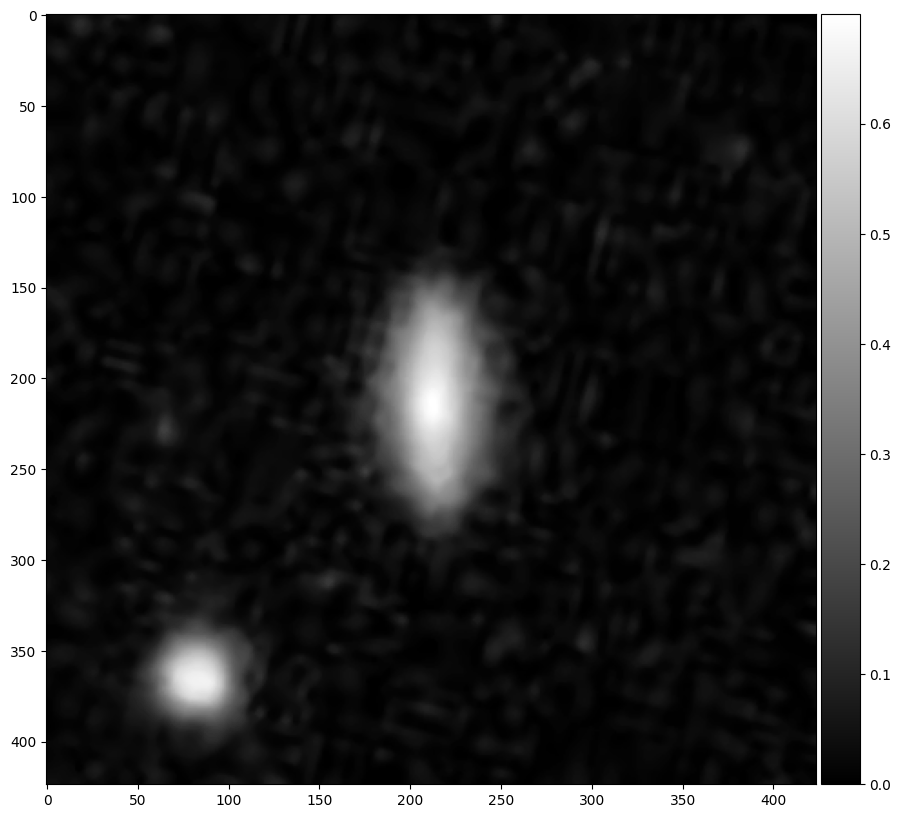

In [40]:
# median filter, replaces each pixel's value with the median value of the intensities in the neighborhood of that pixel
# kernel size = 5, A larger kernel size will have a more significant smoothing effect
def median_preprocessing(img, ksize):
  median_filtered_image = cv2.medianBlur(img, ksize)
  return median_filtered_image

median_filtered_image = median_preprocessing(im_gray, 5)
display_img_colorbar(median_filtered_image)

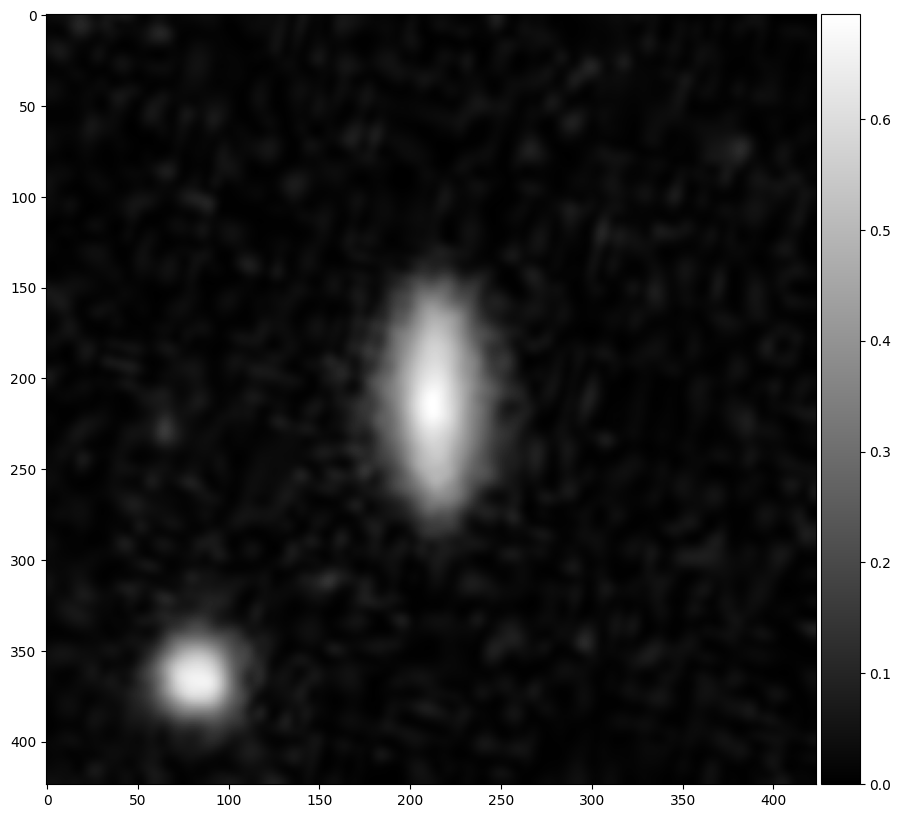

In [41]:
# This filter is more advanced and can reduce noise while keeping edges sharp. It does this by considering both the spatial proximity and the intensity similarity.
def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

bilateral_filtered_image = bilateral_preprocessing(im_gray, 9, 75, 75)
display_img_colorbar(bilateral_filtered_image)

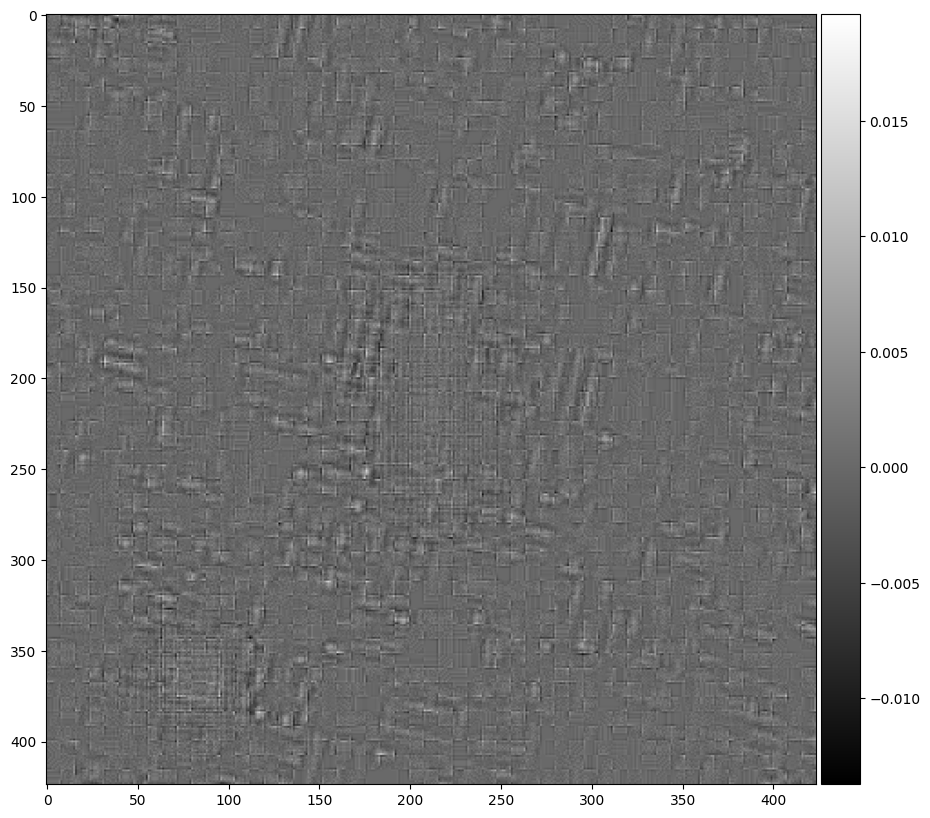

In [42]:
# high pass freqeuncies are noises
def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

high_pass_img = high_pass_preprocessing(im_gray, (3,3), 0)
display_img_colorbar(high_pass_img)

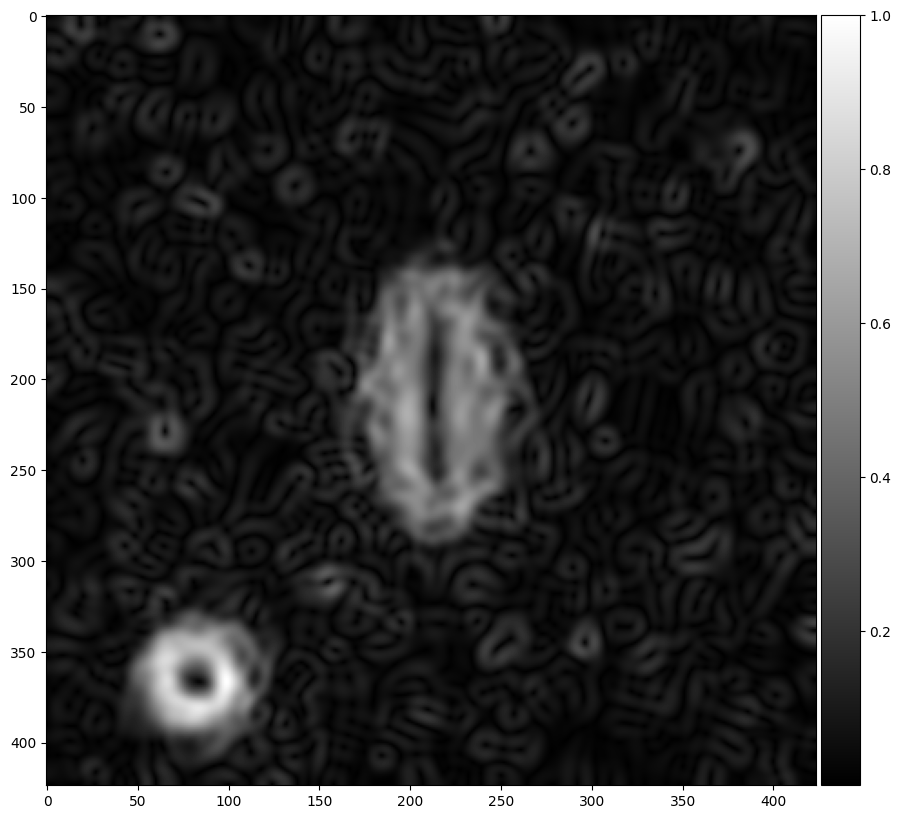

In [43]:
# compute edges of the image
# the larger kernel size is, the clearer the image we have. Small kernal would make the image fuzzy and full of noises.
def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

sobel_img = sobel_preprocessing(bilateral_filtered_image, 31)
display_img_colorbar(sobel_img)

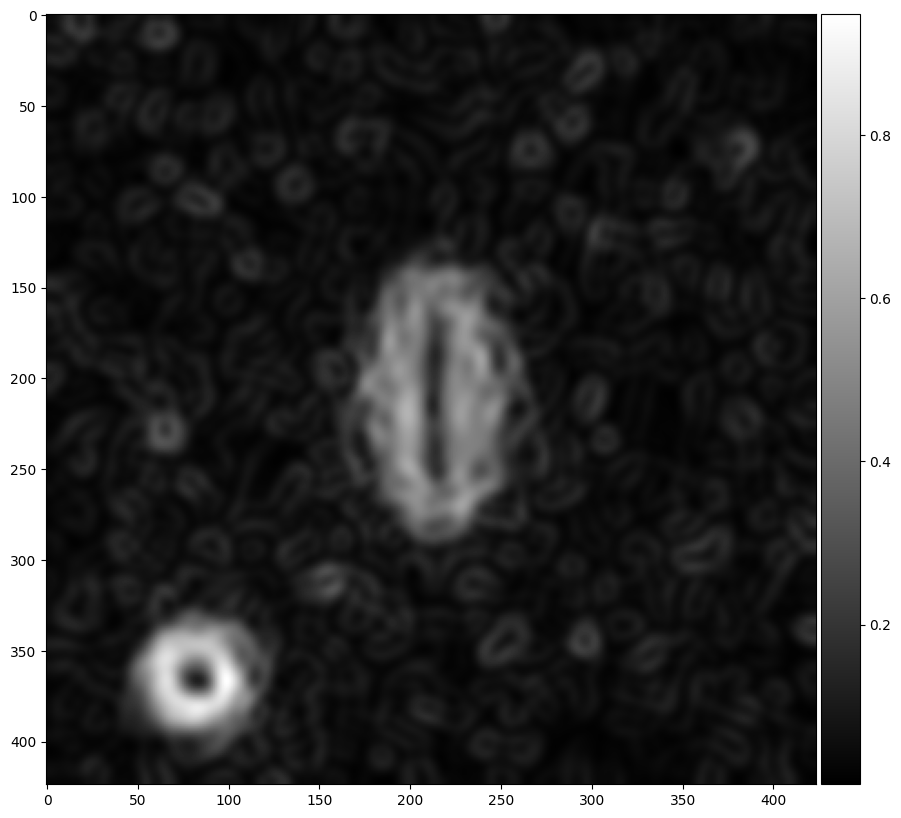

In [44]:
# GaussianBlur before canny to reduce the noise
# Arguments: kernel size (width, height), sigmaX and sigmaY
# Default setting sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
# if the kernel has wider tails, the image will be more blurred or higher sigma

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

blurred_im = gaussian_blur_preprocessing(sobel_img, (7, 7), (16, 10))
display_img_colorbar(blurred_im)

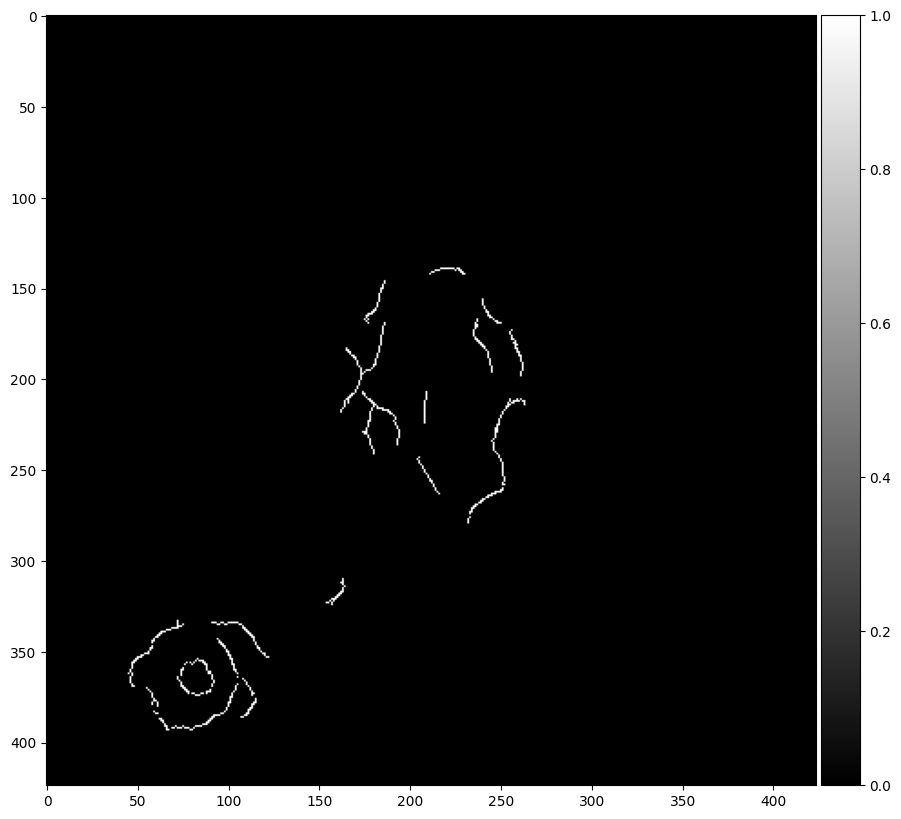

In [45]:
def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

img_canny = canny_filter(blurred_im, 120, 30)
display_img_colorbar(img_canny)

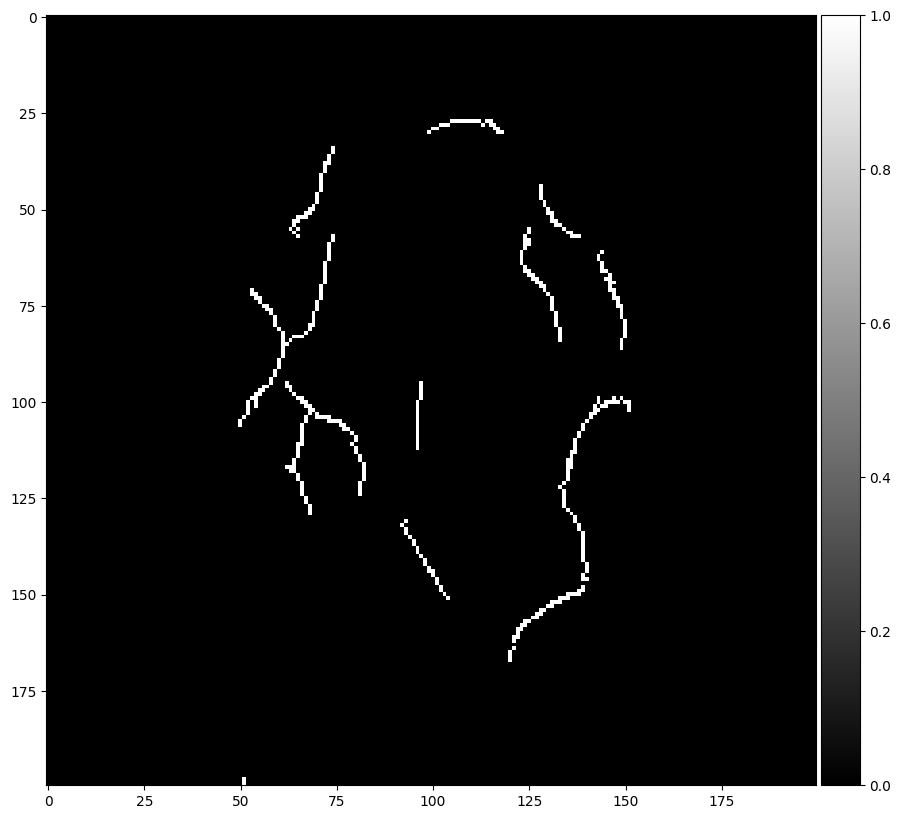

In [46]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

display_img_colorbar(crop_center(img_canny, 200, 200))

In [68]:
def plot_stages(img_list):
  fig, axes = plt.subplots(nrows=1, ncols=len(img_list), figsize=(20, 4))
  for i, img in enumerate(img_list):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  # Turn off axis
  plt.show()

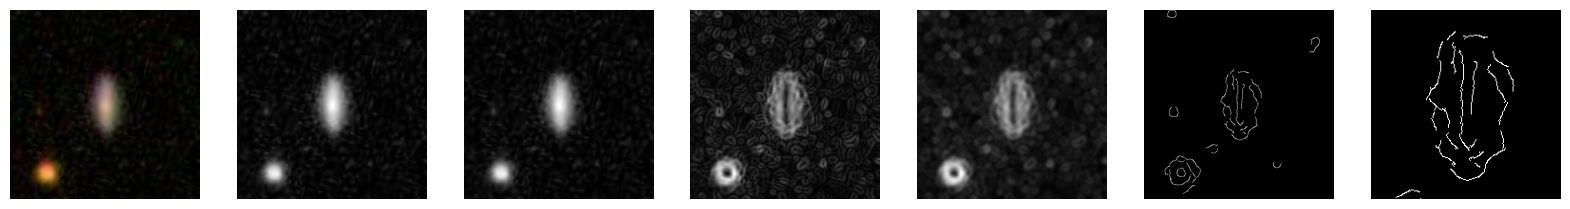

In [118]:
# test 1, bilateral -> sobel -> gaussian_blur -> canny
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

im_bilateral = bilateral_preprocessing(im_gray, 3, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_blurred = gaussian_blur_preprocessing(im_sobel, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 90, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 200, 200)
img_list.append(im_cropped)

plot_stages(img_list)
# display_img_colorbar(im_cropped)

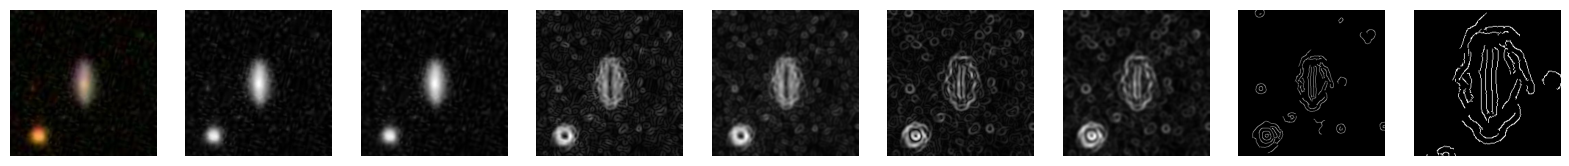

In [117]:
# test 2, bilateral-> sobel -> bilateral -> sobel -> gaussian_blur -> canny
# get the change of the edges: corners
# get the contour of the bright spot in the center
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

im_bilateral = bilateral_preprocessing(im_gray, 5, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_bilateral_2 = bilateral_preprocessing(im_sobel, 9, 75, 75)
img_list.append(im_bilateral_2)

im_sobel_2 = sobel_preprocessing(im_bilateral_2, 31)
img_list.append(im_sobel_2)

im_blurred = gaussian_blur_preprocessing(im_sobel_2, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 90, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 200, 200)
img_list.append(im_cropped)

plot_stages(img_list)
# display_img_colorbar(im_cropped)

8436


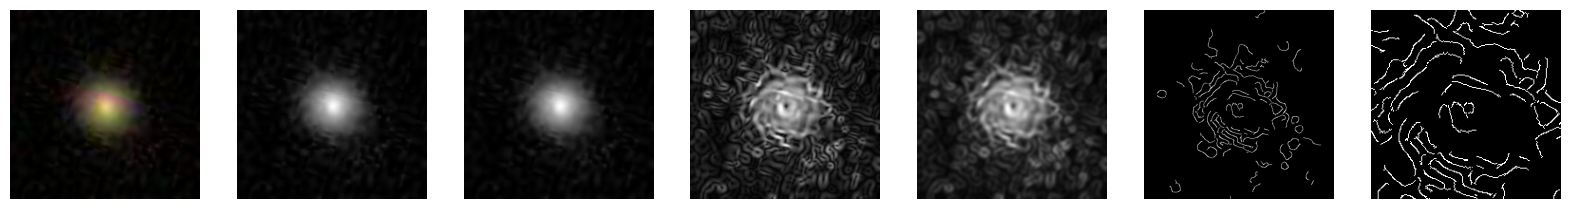

In [120]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/completely round smooth'
image_files = os.listdir(image_dir)
print(len(image_files))

image_path = os.path.join(image_dir, image_files[2])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

im_bilateral = bilateral_preprocessing(im_gray, 5, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_blurred = gaussian_blur_preprocessing(im_sobel, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 90, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 200, 200)
img_list.append(im_cropped)

plot_stages(img_list)

8436


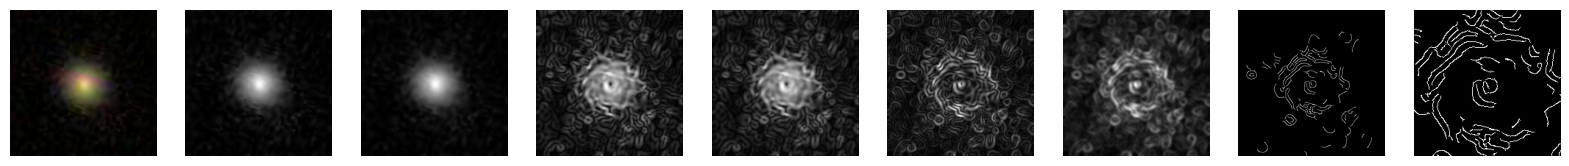

In [121]:
# test 2, bilateral-> sobel -> bilateral -> sobel -> gaussian_blur -> canny
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/completely round smooth'
image_files = os.listdir(image_dir)
print(len(image_files))

image_path = os.path.join(image_dir, image_files[2])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

im_bilateral = bilateral_preprocessing(im_gray, 9, 75, 75)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_bilateral_2 = bilateral_preprocessing(im_sobel, 5, 30, 30)
img_list.append(im_bilateral_2)

im_sobel_2 = sobel_preprocessing(im_bilateral_2, 31)
img_list.append(im_sobel_2)

im_blurred = gaussian_blur_preprocessing(im_sobel_2, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 120, 50)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 200, 200)
img_list.append(im_cropped)

plot_stages(img_list)
# display_img_colorbar(im_cropped)

HOG